Take a uniform grid with step sizes $\Delta t$ in $t$ and $\Delta x$ in $x$, and consider the centred-difference approximation
\begin{equation}
    u_{tt}(x, t) = \frac{u(x, t + \Delta t) - 2u(x, t) + u(x, t - \Delta t)}{(\Delta t)^2} + O((\Delta t)^2),
\end{equation}
and a similar one for $u_{xx}$, to generate the finite-difference scheme
\begin{equation}
    \frac{u_i^{j+1} - 2u_i^j + u_i^{j-1}}{(\Delta t)^2} - \frac{u_{i+1}^j - 2u_i^j + u_{i-1}^j}{(\Delta x)^2} = -q^2\left(\frac{u_{i+1}^j + u_{i-1}^j}{2}\right),
\end{equation}
where $u_i^j$ is an approximation to $u(i\Delta x, j\Delta t)$. (It is possible to use the more natural $-q^2u_i^j$ on the right-hand side, but then a smaller $\Delta t$ may be required for numerical stability. The solution at $t$-level $j + 1$ can thus be found from those at $j$ and $j - 1$.

Clearly the first t-level needs special treatment: for our initial conditions it is sufficient, to the order of accuracy of the scheme, to set $u_i^{-1} = u_i^1$. Furthermore, since we are restricting attention to solutions even in $x$, we need only solve in $0 \leq x \leq L \equiv N\Delta x$ with the additional boundary condition $u_x(0, t) = 0$, which can be implemented in the
finite-difference scheme by setting $u_{-1}^j = u_1^j$. Note that the $u_0^j$ are determined as part of the solution, but the outer-boundary values $u_N^j$ need to be specified.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def solve_klein_gordon(f, L, T, q, Nx, Nt, outer_boundary):
    '''
    Numerically solves the Klein-Gordon equation using a finite-difference scheme.
    Args:
        f: Initial condition u(x, 0) = f(x).
        L: Length of the spatial domain [0, L].
        T: Total time for the simulation.
        q: Parameter from the Klein-Gordon equation.
        Nx: Number of spatial grid points.
        Nt: Number of time steps.
        outer_boundary: Boundary condition at x=L, u(L, t).
    Returns:
        A tuple containing the spatial grid (x), time grid (t) and
        the solution (u) as a 2D array.
    '''
    # Setup grids
    dx = L / (Nx - 1)
    dt = T / (Nt - 1)
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt)
    r = dt / dx

    # Stability condition (Courant-Friedrichs-Lewy) for this scheme
    if r > 1:
        print(f"Stability condition not met. r = {r:.2f} > 1")

    # Initialie solution array
    # u[j, i] corresponds to u_i^j
    u = np.zeros((Nt, Nx))

    # Apply initial conditions
    u[0, :] = f(x)

    # Special treatment for the first time step (j=1)
    # Using u_t(x, 0) = 0
    u[1, 0] = u[0, 0] - 0.5 * (r**2) * (u[0, 1] - 2*u[0, 0] + u[0, 1]) \
              - 0.5 * (dt**2 * q**2) * u[0, 0] # Inner boundary
    for i in range(1, Nx - 1):
        u[1, i] = u[0, i] - 0.5 * (r**2) * (u[0, i+1] - 2*u[0, i] + u[0, i-1]) \
                  - 0.5 * (dt**2 * q**2) * u[0, i]

    # Apply outer boundary at the first calculated step
    u[1, -1] = outer_boundary(t[1])

    # Main loop for time evolution (j > 1)
    for j in range(1, Nt - 1):
        # Update interior points
        for i in range(1, Nx - 1):
            term_xx = (r**2) * (u[j, i+1] - 2*u[j, i] + u[j, i-1])
            term_q = (dt**2 * q**2) * 0.5 * (u[j, i+1] + u[j, i-1])
            u[j+1, i] = 2*u[j, i] - u[j-1, i] + term_xx - term_q

        # Apply boundary conditions
        # Inner boundary at x=0 (u_x(0,t)=0) -> u_{-1}^j = u_{1}^j
        term_xx_0 = (r**2) * (u[j, 1] - 2*u[j, 0] + u[j, 1])
        term_q_0 = (dt**2 * q**2) * 0.5 * (u[j, 1] + u[j, 1])
        u[j+1, 0] = 2*u[j, 0] - u[j-1, 0] + term_xx_0 - term_q_0

        # Outer boundary at x=L
        u[j+1, -1] = outer_boundary(t[j+1])

    return x, t, u

def initial_function(x):
    return np.where(np.abs(x) <= 1, (1 - x**2)**2, 0)

def boundary_function(t):
    return 0.0

def f_tilde(k):
    '''
    Analytical Fourier transform of the initial condition.
    '''
    # Handle k=0 case to avoid division by zero
    k_safe = np.where(k == 0, 1e-9, k)
    term1 = (3 / k_safe**2 - 1) * np.sin(k_safe)
    term2 = (3 / k_safe) * np.cos(k_safe)
    # The value at k=0 is the integral of f(x), which is 16/15
    return np.where(k == 0, 16/15, 8/k_safe**3 * (term1 - term2))

def stationary_phase_approx(x, t, q, f_tilde_func):
    '''
    Stationary-phase approximation.
    '''
    # Valid for |x| < t and t > 0
    mask = (np.abs(x) < t) & (t > 1e-9)
    result = np.zeros_like(x)
    x_m, t_m = x[mask], t

    denom_term = (t_m**2 - x_m**2)**(3/4)
    amp_const = (q**(1/2) * t_m) / (np.sqrt(2 * np.pi) * denom_term)

    k0 = q * x_m / np.sqrt(t_m**2 - x_m**2)
    f_tilde_k0 = f_tilde_func(k0)

    phase = q * np.sqrt(t_m**2 - x_m**2) + np.pi / 4

    result[mask] = amp_const * f_tilde_k0 * np.cos(phase)
    return result

def d_alembert_solution(x, t, f):
    return 0.5 * (f(x + t) + f(x - t))

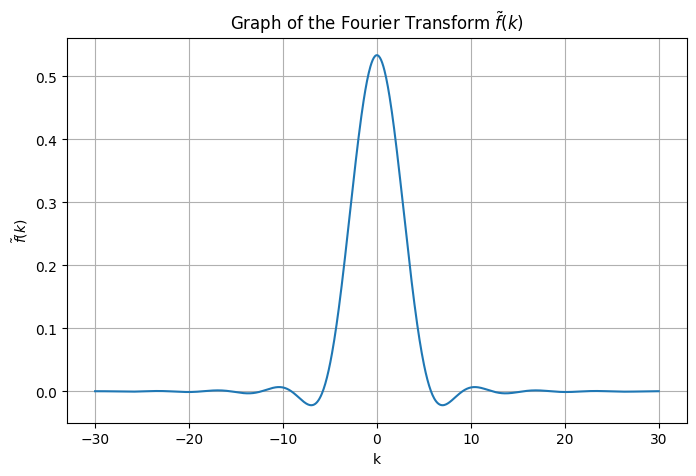

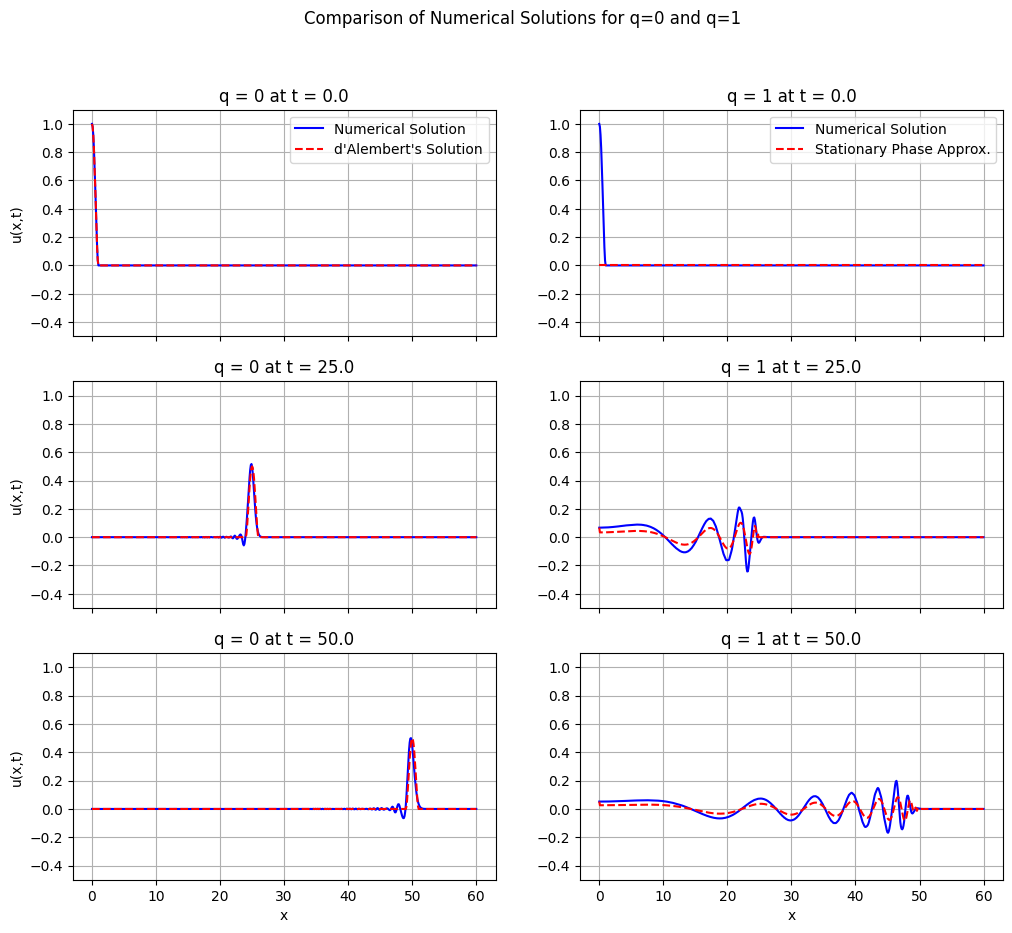

In [29]:
# Plot the Fourier Transform
k_vals = np.linspace(-30, 30, 1000)
ft_vals = f_tilde(k_vals)
plt.figure(figsize=(8, 5))
plt.plot(k_vals, ft_vals)
plt.title(r'Graph of the Fourier Transform $\tilde{f}(k)$')
plt.xlabel('k')
plt.ylabel(r'$\tilde{f}(k)$')
plt.grid(True)
plt.show()

# Parameters
L_domain = 60.0
T_final = 50.0
# Use Δx = 0.1 and Δt = 0.05 for stability (r=0.5)
Nx_points = 601
Nt_steps = 1001

# Run for q=0
x_grid, t_grid, u_q0 = solve_klein_gordon(
    initial_function, L_domain, T_final, 0,
    Nx_points, Nt_steps, boundary_function
)

# Run for q=1
x_grid_q1, t_grid_q1, u_q1 = solve_klein_gordon(
    initial_function, L_domain, T_final, 1,
    Nx_points, Nt_steps, boundary_function
)

# Plot the solutions at representative times
times_to_plot = [0, 25, 50]
fig, axs = plt.subplots(len(times_to_plot), 2, figsize=(12, 10), sharex=True)
fig.suptitle('Comparison of Numerical Solutions for q=0 and q=1')

for i, t_val in enumerate(times_to_plot):
    idx = np.abs(t_grid - t_val).argmin() # Find closest time index

    # Plot for q=0
    ax0 = axs[i, 0]
    ax0.plot(x_grid, u_q0[idx, :], 'b-', label='Numerical Solution')
    # Plot d'Lambert's solution
    ax0.plot(x_grid, d_alembert_solution(x_grid, t_grid[idx], initial_function), 'r--', label="d'Alembert's Solution")
    ax0.set_title(f'q = 0 at t = {t_grid[idx]:.1f}')
    ax0.set_ylabel('u(x,t)')
    ax0.grid(True)
    ax0.set_ylim(-0.5, 1.1)

    # Plot for q=1
    ax1 = axs[i, 1]
    ax1.plot(x_grid, u_q1[idx, :], 'b-', label='Numerical Solution')
    # Superpose stationary phase approximation
    u_approx = stationary_phase_approx(x_grid, t_grid[idx], 1, f_tilde)
    ax1.plot(x_grid, u_approx, 'r--', label='Stationary Phase Approx.')
    ax1.set_title(f'q = 1 at t = {t_grid[idx]:.1f}')
    ax1.grid(True)
    ax1.set_ylim(-0.5, 1.1)

axs[-1, 0].set_xlabel('x')
axs[-1, 1].set_xlabel('x')
axs[0, 0].legend()
axs[0, 1].legend()
plt.show()

The numerical scheme's stability is governed by the Courant-Friedrichs-Lewy (CFL) condition. For the standard wave equation $q=0$, the condition is $\Delta t/\Delta x \leq 1$. The scheme used here is a variation, but this condition remains a reasonable guideline. The spatial domain $L$ need to be sufficiently large to ensure the waves do not reach the boundary before the end time.

The initial condition is $f(x) = (1 - x^2)^2$ for $|x| \leq 1$ and $0$ otherwise. The Fourier transform is given by the integral
\begin{align}
    \tilde{f}(k)
    &= ∫_{-\infty}^\infty (1 - x^2)^2 e^{-ikx}\,dx \\
    &= \left[\frac{16}{k^3}\sin(k) - \frac{16}{k^4}(2x\cos(k) + (k^2x^2-2)\sin(k))\right]_{x = -1}^1 \\
    &= \frac{16}{k^3}\sin(k) - \frac{32}{k^4}\cos(k) + \frac{16}{k^5}(k^2-2)\sin(k) \\
    &= \frac{8}{k^5}((3 - k^2) \sin(k) - 3k\cos(k)).
\end{align}

For $q = 0$, we have the linear wave equation. The initial pulse $f(x)$ instantaneously splits into two identical pulses with half amplitude moving in opposite directions with a constant speed. The shape of the pulses remains unchanged over time as they propagate due to non-dispersion.

For $q = 1$, we have a dispersive effect. The initial pulse still splits and propagates outwards, with the main front travelling at constant speed. The solution evolves into complex wave packets that spread out over time. An oscillatory wake is left behind the main propagating fronts and different frequency components travel at different speeds, dictated by the group velocity, causing the wave packet to change shape. High-frequency (short wavelength) components form the trailing wake, while the lower-frequency components lead the packet. The approximation is best for large $t$ and away from the front $x=t$.

If $q \ll 1$ were non-zero but very small, the behavior would be an intermediate between the two cases observed. For small $t$, the $q^2u$ term in the equation would have a negligible effect, and the solution would behave almost exactly like the linear wave equation. As $t$ becomes large, the cumulative effect of the $q^2u$ term would become significant leading to dispersive effects.